In [1]:
import os
import sys
import glob

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db       as DB
import invisible_cities.io      .pmaps_io      as pmpio
import invisible_cities.core    .fit_functions as fitf
import invisible_cities.core    .exceptions    as excpt
import invisible_cities.reco    .xy_algorithms as XY

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import measurement_string
from icaro           .core .fit_functions import conditional_labels

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"  ] = 16, 12
plt.rcParams[  "font.size"     ] = 40
plt.rcParams[  "grid.linewidth"] =  3
plt.rcParams[  "grid.linestyle"] = ":"

labels = conditional_labels(with_title=False)

In [3]:
datapmt = DB.DataPMT(4841)

In [4]:
filename_pattern = "$IC_DATA/Kr/4734/pmaps*.h5"

In [5]:
filenames = glob.glob(os.path.expandvars(filename_pattern))[:20]

pmaps = {}
for filename in filenames:
    pmaps_ = pmpio.load_pmaps(filename)
    for key in pmaps_: assert key not in pmaps
    pmaps.update(pmaps_)

In [6]:
nS1 = []
active = datapmt.Active.values.astype(bool)
for pmap in pmaps.values():
    n = 0
    for s1 in pmap.s1s:
        enes = s1.pmts.sum_over_sensors
        eot  = enes[enes > 0.5]
        if not (4   < np.size(eot) <   20): continue
        if not (0.5 < np.min (eot) < 2500): continue
        if not (0.5 < np.max (eot) < 1000): continue
        n += 1
    nS1.append(n)

In [7]:
np.save("/Users/Gonzalo/github/tese/dat/s1_candidates", nS1)

In [4]:
import sys
import os
import contextlib
pykstd = sys.stdout

In [7]:
pykstd, sys.stdout

(<ipykernel.iostream.OutStream at 0x10d21e668>,
 <ipykernel.iostream.OutStream at 0x10d21e668>)

In [6]:
@contextlib.contextmanager
def silent():
    previous_stdout = sys.stdout
    pykstd.write("prev1" +  str(previous_stdout))
    sys.stdout = open(os.devnull, "w")
    pykstd.write("prev2" +  str(previous_stdout))
    yield
    pykstd.write("prev3" +  str(previous_stdout))
    sys.stdout.close()
    pykstd.write("prev4" +  str(previous_stdout))
    sys.stdout = previous_stdout
    pykstd.write("prev5" +  str(previous_stdout))

with silent():
    pass

prev1<ipykernel.iostream.OutStream object at 0x10d21e668>prev2<ipykernel.iostream.OutStream object at 0x10d21e668>prev3<ipykernel.iostream.OutStream object at 0x10d21e668>prev4<ipykernel.iostream.OutStream object at 0x10d21e668>prev5<ipykernel.iostream.OutStream object at 0x10d21e668>

In [ ]:
print(1)

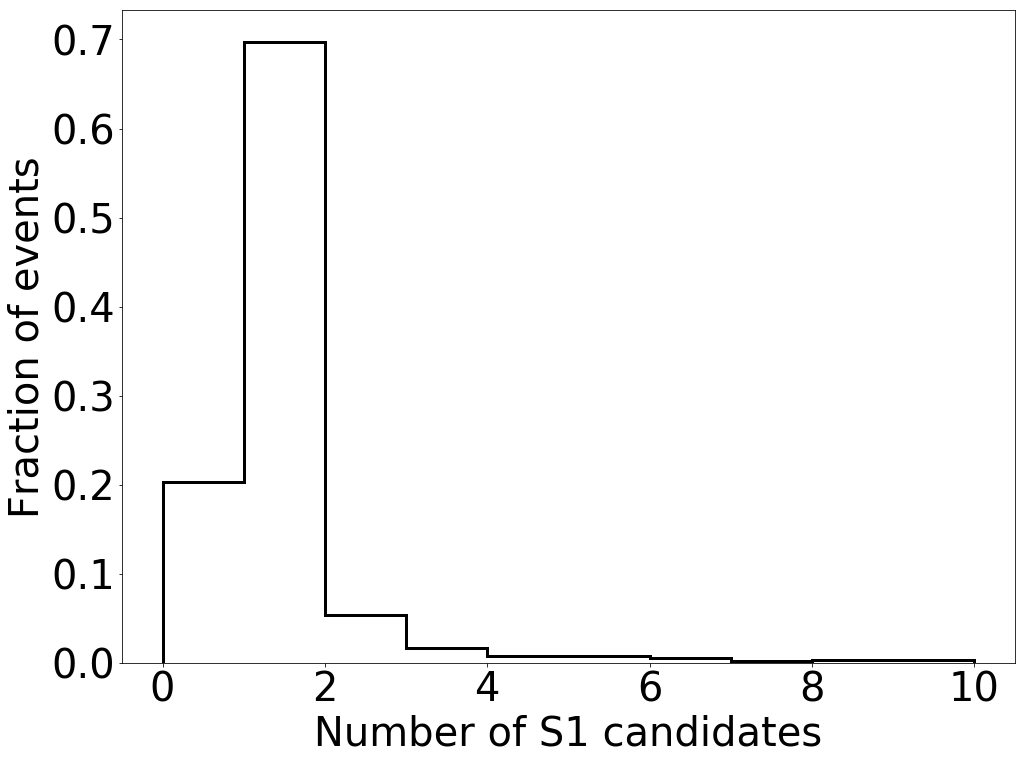

In [122]:
plt.hist(nS1, np.arange(11), normed=True, ec="k", histtype="step", lw=3)
plt.xlabel("Number of S1 candidates")
plt.ylabel("Fraction of events")

plt.savefig("/Users/Gonzalo/github/papers/KrRunII/imgKr/ns1.png", bbox_inches="tight")

In [5]:
ep = np.array([1.0, 2.00, 2.80, 3.00, 3.8, 4.0,  5.0])
jj = np.array([0.8, 0.04, 0.01, 0.03, 0.5, 3.0, 30.0])

from scipy.interpolate import interp1d

Jf = interp1d(ep, jj, bounds_error=False, fill_value="extrapolate")

In [28]:
EoverP = np.linspace(0.75, 5, 100)
F      = 0.15
J      = Jf(EoverP)
gap    = 0.6
k      = 6e-3
Ne     = 112237
YoverP = np.clip(136 * EoverP - 99, 1e-20, np.inf) * gap


Rlims  = 0,    3
Ylims  = 0, 5250
Rticks = np.linspace(*Rlims, 6)
Yticks = np.linspace(*Ylims, 6)
Rstrs  = ["{:.1f}".format(t) for t in Rticks]
Ystrs  = ["{:.0f}".format(t) for t in Yticks]
scale  = Rlims[1] / Ylims[1]

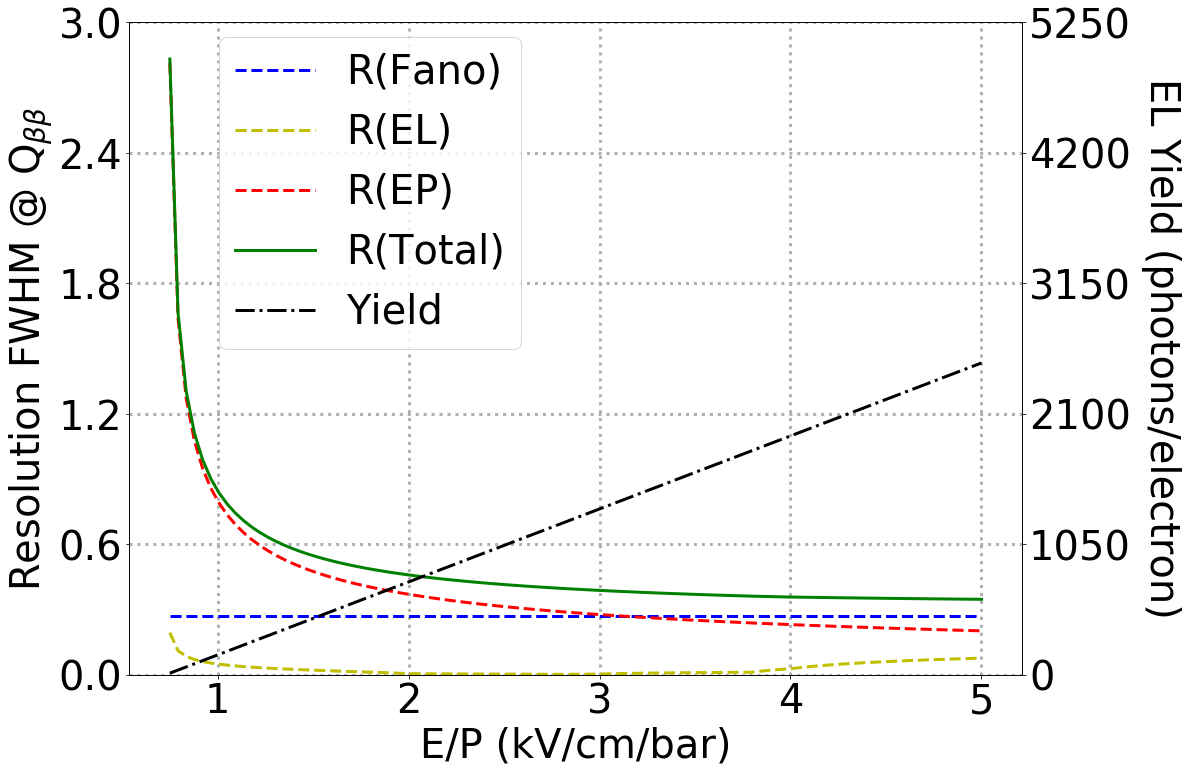

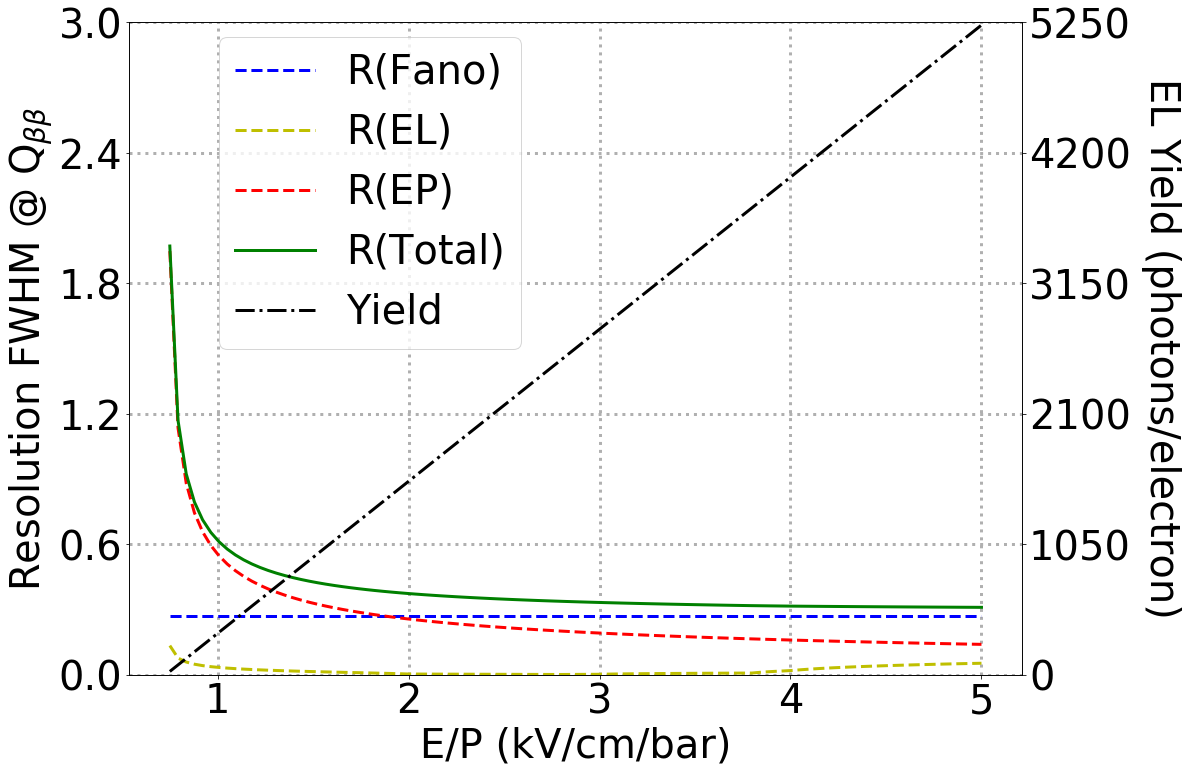

In [32]:
for P in [7.2, 15]:
    Nel    = YoverP * P
    Nep    = k * Ne * Nel

    Rfano = 235 * np.sqrt(F / Ne) * np.ones_like(EoverP)
    Rel   = 235 * np.sqrt(J / Ne / Nel)
    Rep   = 235 * np.sqrt(1.25 / Nep)
    Rtot  = 235 * np.sqrt(F / Ne + J / Ne / Nel + 1.25 / Nep)

    plt.figure()
    plt.plot(EoverP, Rfano, "b--", lw=3, label="R(Fano)" )
    plt.plot(EoverP, Rel  , "y--", lw=3, label="R(EL)"   )
    plt.plot(EoverP, Rep  , "r--", lw=3, label="R(EP)"   )
    plt.plot(EoverP, Rtot , "g-" , lw=3, label="R(Total)")

    plt.grid(which="both")

    plt.ylim(*Rlims)
    plt.yticks(Rticks, Rstrs)

    plt.xlabel("E/P (kV/cm/bar)")
    plt.ylabel("Resolution FWHM @ Q$_{\\beta\\beta}$")

    plt.plot(EoverP, Nel*scale, "k-." , lw=3, label="Yield")

    plt.legend(loc=(0.1, 0.5))

    ax2 = plt.gca().twinx()
    ax2.set_ylim       (*Ylims )
    ax2.set_yticks     ( Yticks)
    ax2.set_yticklabels( Ystrs )
    ax2.set_ylabel("EL Yield (photons/electron)", rotation=-90, labelpad=50);

    plt.savefig(f"/Users/Gonzalo/github/papers/NEWPOOL/pool/imgKr/resolution_{P}_bar.png",
                bbox_inches="tight")

In [337]:
from itertools import permutations
from functools import lru_cache

@lru_cache(maxsize=10000)
def factorial(n):
    return n * factorial(n-1) if n > 1 else 1

afactorial = np.vectorize(factorial)

def are_different(a, b, c):
    return not (a == b == c)

def less_than_three_consecutive_equal(seq):
    return all(are_different(*seq[i:i+3]) for i in range(len(seq) - 3))

In [279]:
result = {}

In [281]:
for N in range(2, 7):
    print(N)
    result[N] = len(list(filter(less_than_three_consecutive_equal, permutations([0]*N + [1]*N))))

2
3
4
5
6


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in long_scalars
  
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ nan,  nan,  nan]), nan)

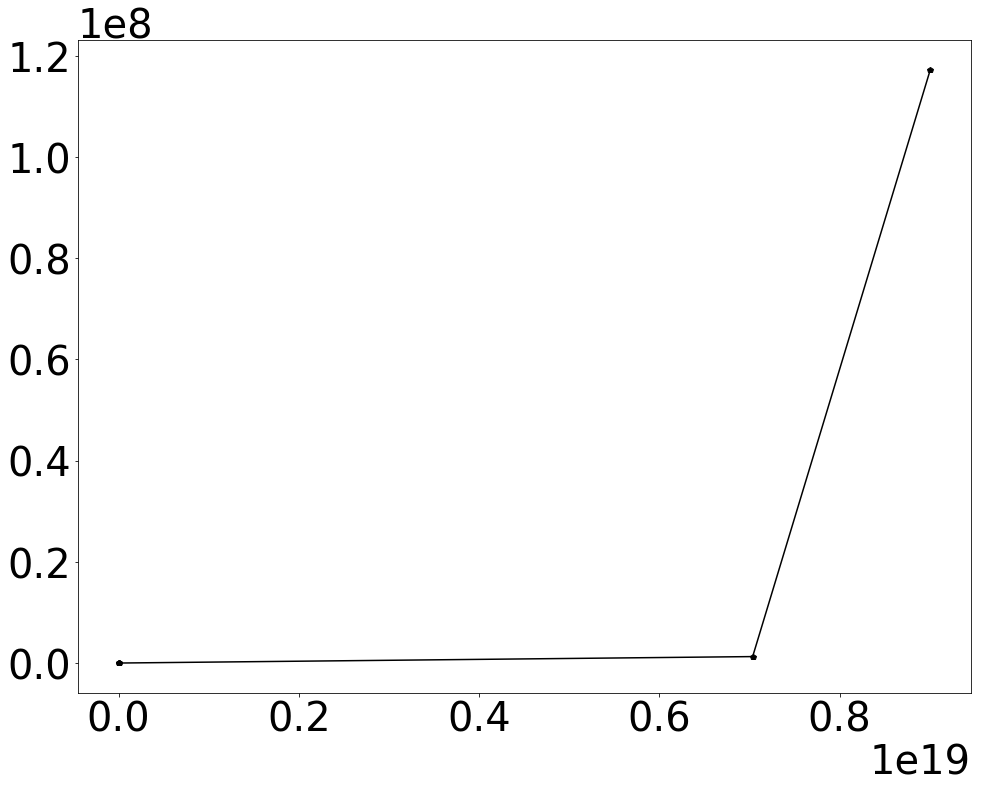

In [346]:
x, y = map(np.array, map(list, zip(*result.items())))
x = afactorial(x**2)
f = lambda x, a, b, p: a + b*x**p
f = fitf.fit(f, x, y, (0, 1, 1), maxfev=int(1e6))
plt.plot(x, y, "p-k")
#plt.plot(afactorial(x), y, "p-k")
plt.plot(x, f.fn(x), "-r")
f.values, f.chi2

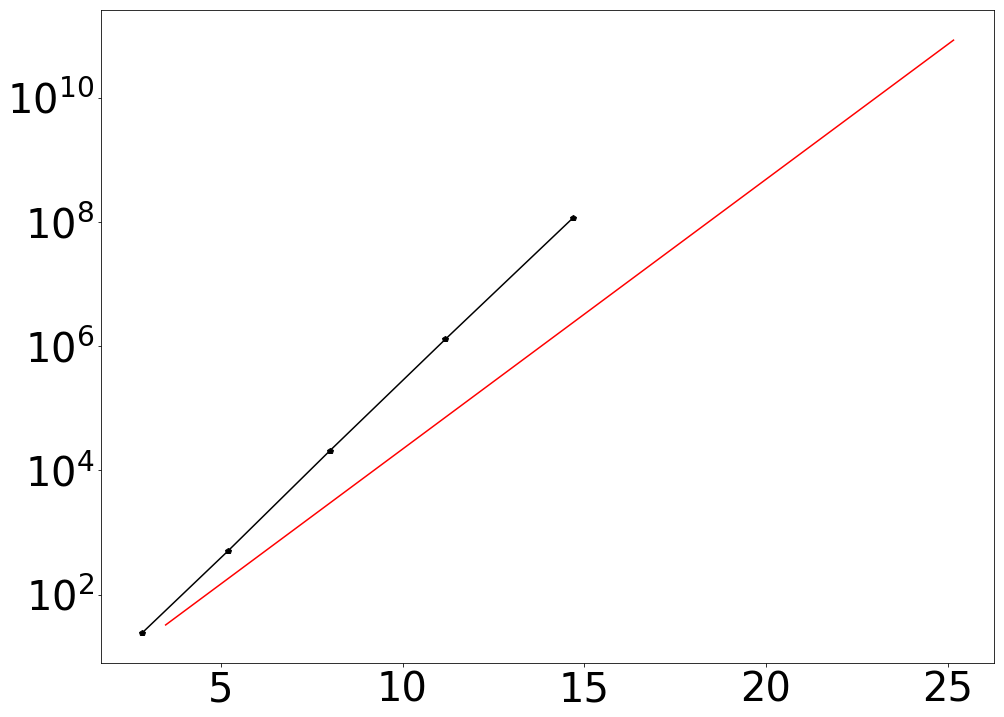

In [302]:
xx = np.linspace(2, 6)**1.8
yy = np.exp(xx)
plt.plot(xx, yy, "r-")

In [285]:
result

{2: 24, 3: 504, 4: 20736, 5: 1296000, 6: 117158400}

In [292]:
9*8*7#*6*5*4*3*2

504

11880